# 강화학습 모델 생성

## 데이터 선언

In [2]:
import mysql.connector
from mysql.connector import Error

# 데이터베이스 연결 설정
try :
    connection = mysql.connector.connect(
        host='112.167.124.86',          # 데이터베이스 서버 주소
        user='root',      # 데이터베이스 사용자 이름
        password='password',  # 사용자 비밀번호
        database='hydro_project'   # 접근할 데이터베이스 이름
    )

    if connection.is_connected():
                print('MySQL 데이터베이스에 성공적으로 연결되었습니다.')
                cursor = connection.cursor()

except Error as e:
        print(f"MySQL 데이터베이스 에러: {e}")

MySQL 데이터베이스에 성공적으로 연결되었습니다.


In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)  # 전체 행 보기

# 데이터 조회
cursor.execute("SELECT * FROM e_2 WHERE DATE(일시) = '2023-06-23'")
result = cursor.fetchall()

# 열 이름 리스트
columns = [
    '일시', '전압', '전류', '출력_DC', '전압(RS)', '전압(ST)', '전압(TR)',
    '전류(R)', '전류(S)', '전류(T)', '출력_AC', '누적발전량', '주파수',
    '역률', '경사', '수평', '모듈', '외기'
]

# 데이터를 DataFrame으로 변환
E_2 = pd.DataFrame(result, columns=columns)
E_2 = E_2[['일시','출력_AC']]
E_2.to_csv("2공.csv", index=False)


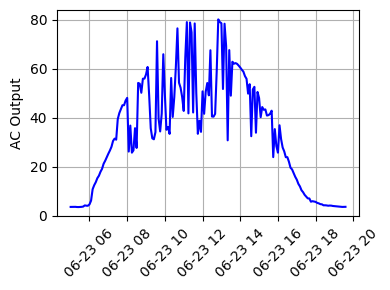

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the provided CSV file
file_path = '2공.csv'
E_2 = pd.read_csv(file_path)

# Convert '일시' to datetime and set it as index
E_2['일시'] = pd.to_datetime(E_2['일시'])
E_2.set_index('일시', inplace=True)

# Plotting the data
plt.figure(figsize=(4, 3))
plt.plot(E_2.index, E_2['출력_AC'], label='AC Output', color='blue')
plt.ylabel('AC Output')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:

# Load the uploaded CSV file
file_path = '2공.csv'

E_2 = pd.read_csv(file_path)

# Remove unnecessary column and convert '일시' to datetime
E_2['일시'] = pd.to_datetime(E_2['일시'])

# Set '일시' as the index
E_2.set_index('일시', inplace=True)

# Create a new datetime range for the desired period
new_index = pd.date_range(start='2023-06-23 00:00:00', end='2023-06-23 23:55:00', freq='5T')

# Reindex the dataframe with the new datetime range and interpolate missing values
data_reindexed = E_2.reindex(new_index).interpolate()
data_reindexed.loc[data_reindexed.index >= '2023-06-23 19:40:00', '출력_AC'] = 0
data_reindexed.fillna(0, inplace=True)

# Display the first few rows to verify changes
E_2 = data_reindexed


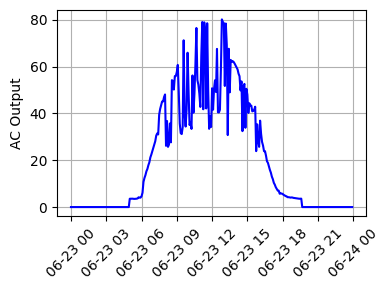

In [17]:
# 그래프 그리기
plt.figure(figsize=(4, 3))  # 그래프 크기 설정
plt.plot(E_2.index, E_2['출력_AC'], label='AC Output', color='blue')  # 선 그래프 그리기
plt.ylabel('AC Output')  # y축 라벨
plt.grid(True)  # 격자 보이기
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [4]:
import pandas as pd
pd.set_option('display.max_rows', None)  # 전체 행 보기

# 데이터 조회
cursor.execute("SELECT * FROM cost")
result = cursor.fetchall()

# 열 이름 리스트
columns = [
    'time', 'spring', 'summer', 'fall', 'winter'
]

# 데이터를 DataFrame으로 변환
costData = pd.DataFrame(result, columns=columns)
costData = costData['summer']

In [5]:
# Long-term simulation data code
# CSV Data load
import pandas as pd
import numpy as np
from scipy.io import loadmat
data = pd.read_csv('2020_load_data.csv')

# Long-term simulation data code
import numpy as np

# 시작 값, 끝 값, 간격 설정
start = 300
end = 86400
interval = 300

# 리스트 생성
time_intervals = list(range(start, end + interval, interval))
# numpy 배열로 변환하고 2D 배열로 reshape
time = np.array(time_intervals).reshape(-1, 1).flatten()

#전력 단가 데이터
dateData = np.array(data['datetime']).reshape(-1,288,1)
dateData = dateData.flatten()

costData = np.array(costData).flatten()
solarData = np.array(E_2['출력_AC']).flatten()

loadData = np.array(data['load']).reshape(-1,288,1) * 5
loadData = loadData.flatten()

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(solarData), "차원" , solarData.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )

자료형: <class 'numpy.ndarray'> 차원 (288,)
자료형: <class 'numpy.ndarray'> 차원 (288,)
자료형: <class 'numpy.ndarray'> 차원 (105408,)
자료형: <class 'numpy.ndarray'> 차원 (288,)


In [6]:
loadData = loadData[0:288]

## 수전해 함수 선언

In [7]:
def P2G(power_kW, time_hours=1):
    """
    잉여 전력[kW] -> 수소 가스[Kg]
    """
    efficiency = 0.7  # Efficiency of the process
    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg

    hydrogen_produced_kg = (power_kW * time_hours * efficiency * heating_value_hydrogen) / 1000
    return hydrogen_produced_kg

# Example usage:
power = 100  # Power in kW

# Calculate hydrogen production for 1 hour
hydrogen_output = P2G(power)
print(f"Produced hydrogen: {hydrogen_output:.5f} kg")

Produced hydrogen: 2.33310 kg


In [8]:
# 남은 수소를 다시 잉여 전력으로
def P2Ga(hydrogen_produced_kg, time_hours=1):
    """
    남은 수소 가스를 다시 잉여 전력으로 변환
    """
    efficiency = 0.7  # Efficiency of the process
    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg

    power_kW = (hydrogen_produced_kg * 1000) / (time_hours * efficiency * heating_value_hydrogen)
    return power_kW

# Example usage:
power = 2.33310  # Power in kW

# Calculate hydrogen production for 1 hour
hydrogen_output = P2Ga(power)
print(f"Produced hydrogen: {hydrogen_output:.5f} kWh")

Produced hydrogen: 100.00000 kWh


In [9]:
# 수소 -> 전력
def G2P(hydrogen_kg):
    """
    Calculate the amount of electricity produced from hydrogen using a PEM fuel cell.

    Parameters:
    hydrogen_kg (float): The amount of hydrogen used in kilograms.
    fuel_cell_efficiency (float): The efficiency of the fuel cell (0-1).

    Returns:
    float: The amount of electricity produced in kilowatt-hours.
    """
    efficiency = 0.5  # Efficiency of the fuel cell

    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg
    electricity_produced_kWh = heating_value_hydrogen * efficiency * hydrogen_kg
    return electricity_produced_kWh

# Example usage:
hydrogen_amount = 2.33310  # Amount of hydrogen in kg
# Calculate electricity production
electricity_output = G2P(hydrogen_amount)
print(f"Electricity produced: {electricity_output:.5f} kWh")

Electricity produced: 38.88111 kWh


In [10]:
# 가스를 수소로 바꿨을 때 x만큼 필요함. 얼만큼의 수소를 쓸지 계산할 때
def G2Pa(tNeedPower):
    """
    X의 전력을 내기 위해 수소 탱크에서 필요한 수소[kg]\n
    필요한 수소[kg] = 전력 / (33.33 * 0.5)
    """
    efficiency = 0.5  # Efficiency of the fuel cell

    heating_value_hydrogen = 33.33  # Heating value of hydrogen in kWh/kg
    tNeedHydrogen = tNeedPower / (heating_value_hydrogen * efficiency) 
    return tNeedHydrogen

# Example usage:
hydrogen_amount = 38.88111 # Amount of hydrogen in kg
# Calculate electricity production
electricity_output = G2Pa(hydrogen_amount)
print(f"Electricity produced: {electricity_output:.5f} Kg")

Electricity produced: 2.33310 Kg


## 강화학습 환경 설정

In [11]:
import numpy as np
import gym
from gym import spaces

# 전력망 환경 클래스 정의
class PowerGridEnv(gym.Env):
    def __init__(self):
        self.solar_data = solarData
        self.load_data = loadData
        self.price_data = costData

        self.HydroCap = 200  # 수소 저장 장치 용량 [kg]
        HydrogenEnergyDensity = 33.33 # 수소 1Kg 당 [kWh]
        self.HydrogenEnergy = self.HydroCap * HydrogenEnergyDensity # 총 에너지 용량
        
        self.Hydrogen = 0.5 * self.HydroCap
        self.HydrogenMin = 0.2 * self.HydroCap
        self.HydrogenMax = 0.9 * self.HydroCap

        self.total_grid_cost = 0
        self.state = None

        # 배터리 상태
        self.observation_space = spaces.Box(low=np.array([0]), high=np.array([100]))
        
        # 액션 종류
        self.action_space = spaces.Discrete(7)
        self.data_pointer = 0
        

    def reset(self):
        self.data_pointer = 0
        self.Hydrogen = 0.5 * self.HydroCap  # 수소 가스 상태
        self.total_grid_cost = 0
        action = 0
        reward = 0
        done = False

        tP2G = 0
        tG2P = 0
        tNeedPower = 0

        self.state = [self.solar_data[0], self.load_data[0], (self.Hydrogen/self.HydroCap) * 100, (tP2G/self.HydroCap) * 100, ((-tG2P/self.HydroCap) * 100), action, self.total_grid_cost]
        return np.array(self.state), reward, done, {"cost" : self.total_grid_cost}

    
    def render(self, mode='human'):
        # 가정: self.state는 환경의 현재 상태를 나타냅니다.
        # 간단한 텍스트 출력으로 상태를 표현합니다.
        print(f"Current state: {self.state}")
        
    def step(self, action):
        reward = 0
       
        tPV = self.solar_data[self.data_pointer]    # 스탭 당 태양광 발전량
        tLoad = self.load_data[self.data_pointer]   # 스탭 당 부하량
        tPrice = self.price_data[self.data_pointer] # 스탭 당 전력 가격

        tP2G = 0
        tG2P = 0
        tNeedPower = 0

        # 액션에 따른 배터리 및 그리드 상호작용
        if action == 0 : # 태양광 O 수소 X 그리드 X
            if tPV >= tLoad :
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # 수소 탱크의 충전 가능(kg)
                    # 최대 충전량 - 현재 충전량 = 충전 가능량
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 가스량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice

            else : # tLoad > tPV
                # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                tNeedPower = tLoad - tPV
                tG2P = G2Pa(tNeedPower) # 필요한 수소 가스 계산[kg]

                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 충전하고 남은 수소[kg]
                tG2P = tPowerDisChg
                                
                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice


        elif action == 1 : # 태양광 O 수소 O 그리드 X
            if tLoad > tPV :
                # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                tNeedPower = tLoad - tPV
                tG2P = G2Pa(tNeedPower) # 필요한 수소 가스 계산[kg]

                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 방전하고 남은 전력량
                tG2P = tPowerDisChg

                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice


            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice

    
        elif action == 2 : # 태양광 O 수소 X 그리드 O
            if tLoad > tPV :
                tNeedPower = tLoad - tPV # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                if tNeedPower > 0 : # 전력이 더 필요할 경우
                    self.total_grid_cost += tNeedPower * tPrice
                    reward = tNeedPower * tPrice

            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice


        elif action == 3 : # 태양광 O 수소 O 그리드 O
            if tLoad > tPV :
                # 태양광 발전량으로 커버한 뒤 필요한 전력을 계산
                tNeedPower = tLoad - tPV
                tG2P = G2Pa(tNeedPower) # 필요한 수소 가스 계산[kg]

                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 충전하고 남은 전력량
                tG2P = tPowerDisChg
                
                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice
             

            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice
                        reward = -P2Ga(tSurplusChg) * tPrice
                            

        elif action == 4 : # 태양광 X 수소 O 그리드 X
            if tLoad > tPV :
                # 필요한 수소 가스 계산[kg]
                tG2P = G2Pa(tLoad)
                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 충전하고 남은 전력량
                tG2P = tPowerDisChg

                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice
            
            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg
                    
                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice 
                        reward = -P2Ga(tSurplusChg) * tPrice 


        elif action == 5 : # 태양광 X 수소 X 그리드 O
            self.total_grid_cost += tLoad * tPrice
            reward = tLoad * tPrice


        elif action == 6 : # 태양광 X 수소 O 그리드 O
            if tLoad > tPV :
                # 필요한 수소 가스 계산[kg]
                tG2P = G2Pa(tLoad)
                # 수소 탱크의 방전 가능(%)
                tPossible_Hydrogen = self.Hydrogen - self.HydrogenMin

                # 수소 텡크에서 사용할 양(L) 계산
                tPowerDisChg = min(tG2P, tPossible_Hydrogen) # 필요한 전력이랑 배터리 뱡젼 가능량을 비교해서 더 작은 값을 방전
                tSurplusChg = tG2P - tPowerDisChg # 방전하고 필요한 전력량
                tG2P = tPowerDisChg

                # 배터리를 방전했을 때 20~80% 일 때
                if ((self.Hydrogen - tPowerDisChg) > self.HydrogenMin) and ((self.Hydrogen - tPowerDisChg) < self.HydrogenMax) :
                    self.Hydrogen -= tPowerDisChg
                # 배터리를 방전했을 때 20% 이하일 때
                else :
                    self.Hydrogen -= tPowerDisChg
                    self.total_grid_cost += G2P(tSurplusChg) * tPrice
                    reward = G2P(tSurplusChg) * tPrice
            
            else : # tLoad < tPV 
                tSurplusPower = tPV - tLoad # 잉여 전력 계산 -> 잉여 전력이 있다면 수소로 변환 후 저장
                if tSurplusPower > 0 : 
                    # Power[kW] to Gas[kg]
                    tP2G = P2G(tSurplusPower) # 잉여 전력 -> 수소 가스로 변환
                    
                    # 수소 탱크의 충전 가능(kg)
                    tPossible_Hydrogen = self.HydrogenMax - self.Hydrogen

                    # 수소 탱크에 충전할 전력 계산
                    tPowerChg = min(tP2G, tPossible_Hydrogen) # 잉여 수소 가스랑 수소 탱크 충전 가능량을 비교해서 더 작은 값을 충전
                    tSurplusChg = tP2G - tPowerChg # 충전하고 남은 전력량
                    tP2G = tPowerChg

                    # 배터리를 충전했을 때 20~80% 일 때
                    if ((self.Hydrogen + tPowerChg) > self.HydrogenMin) and ((self.Hydrogen + tPowerChg) < self.HydrogenMax) :
                        self.Hydrogen += tPowerChg
                    # 배터리를 충전했을 때 80% 이상일 때
                    else :
                        self.Hydrogen += tPowerChg
                        self.total_grid_cost -= P2Ga(tSurplusChg) * tPrice 
                        reward = -P2Ga(tSurplusChg) * tPrice 


        # 데이터 포인터 갱신
        if self.data_pointer >= len(self.solar_data) - 1:
            done = True
        else:
            done = False
            self.data_pointer += 1

        # reward = 1 if done else 0
        self.state = [tPV, tLoad, (self.Hydrogen/self.HydroCap) * 100, (tP2G/self.HydroCap) * 100, ((-tG2P/self.HydroCap) * 100), action, self.total_grid_cost]
        return np.array(self.state), reward, done, {"cost" : self.total_grid_cost}


# # 환경 인스턴스 생성 및 초기화
# env = PowerGridEnv()
# state = env.reset()
# done = False

# print("    PV     Load    SOC(%)   충전량    방전량    액션   누적 비용")

# while not done:
#     action = env.action_space.sample()  # 무작위 액션
#     state, reward, done, info = env.step(action)
    
#     print("", state, "보상", reward)


In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

alpha = 0.05    # 학습률
gamma = 0.9  # 할인율
epsilon = 0.1   # 탐험률

# 환경 초기화
env = PowerGridEnv()
state_size = len(loadData)
action_size = env.action_space.n

q_table = np.zeros((state_size, action_size))

cost_table = []
best_action_table = []
min_cost = float('inf')  # 최소 비용을 기록하기 위한 변수

random.seed(80)

# 학습 과정
for i in tqdm(range(100000)):  # 여기에 tqdm 적용
    num = 0
    action_table = []
    state = env.reset()
    done = False
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmin(q_table[num])

        action_table.append(action)

        next_state, reward, done, info = env.step(action)
        old_value = q_table[num, action]
        next_max = np.max(q_table[num])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[num, action] = new_value
        num += 1

        # 비용 최소화 조건 검사
        if done and info['cost'] < min_cost:
            min_cost = info['cost']
            best_action_table = action_table  # 최적 상태 갱신
        
    cost_table.append(next_state[6])

# pd.DataFrame(cost_table).to_csv("/Users/happy/Desktop/캡스톤/matlab_to_python(Hydrogen)/save_point/best_cost_table.csv")
# pd.DataFrame(best_action_table).to_csv("/Users/happy/Desktop/캡스톤/matlab_to_python(Hydrogen)/save_point/best_action_table.csv")


/opt/miniconda3/envs/hb/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
100%|██████████| 100000/100000 [02:43<00:00, 612.86it/s]


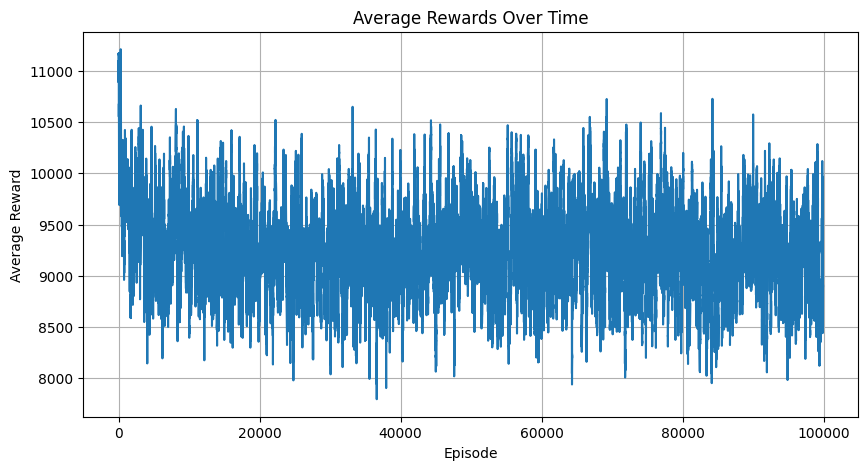

In [19]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# 보상의 이동 평균 계산
moving_avg_rewards = moving_average(cost_table, 100)  # 1000 에피소드 평균

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(moving_avg_rewards)
plt.title('Average Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()


In [15]:
print(min_cost)

0


In [16]:
done = False
env.reset()
cost = 0
soc = []
grid = []
num=0

while not done:
    action = best_action_table[num]

    state, reward, done, info = env.step(action)
    soc.append(state[2])
    grid.append(reward)
    cost += reward
    num += 1
    env.render()


Current state: [0.0, 8.1599, 49.75517851785178, 0.0, -0.24482148214821486, 0, 0]
Current state: [0.0, 8.000350000000001, 49.515144014401436, 0.0, -0.24003450345034508, 0, 0]
Current state: [0.0, 7.8687, 49.27905940594059, 0.0, -0.23608460846084606, 6, 0]
Current state: [0.0, 7.7491, 49.04656315631563, 0.0, -0.23249624962496251, 6, 0]
Current state: [0.0, 7.6258, 48.81776627662766, 0.0, -0.2287968796879688, 1, 0]
Current state: [0.0, 7.51145, 48.592400240024, 0.0, -0.22536603660366036, 0, 0]
Current state: [0.0, 7.4144, 48.369945994599455, 0.0, -0.22245424542454245, 6, 0]
Current state: [0.0, 7.332, 48.149963996399634, 0.0, -0.21998199819981998, 0, 0]
Current state: [0.0, 7.2440999999999995, 47.932619261926185, 0.0, -0.21734473447344735, 3, 0]
Current state: [0.0, 7.1775, 47.71727272727272, 0.0, -0.21534653465346537, 6, 0]
Current state: [0.0, 7.11385, 47.50383588358835, 0.0, -0.21343684368436847, 3, 0]
Current state: [0.0, 7.0562000000000005, 47.29212871287128, 0.0, -0.2117071707170717

In [17]:
# 시작 값, 끝 값, 간격 설정
start = 300
end = 300 * 12 * 24 * 1
interval = 300

# 리스트 생성
time_intervals = list(range(start, end + interval, interval))

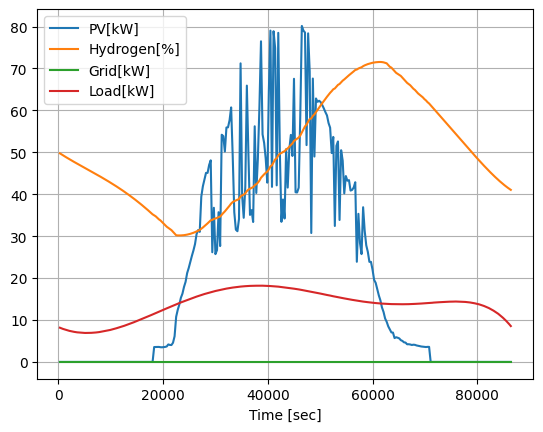

In [18]:
import matplotlib.pyplot as plt

time = time_intervals
# Assuming Ppv, Pbatt, Pgrid, Pload are obtained from battSolarOptimize
plt.plot(time, solarData, time, soc, time, (grid / costData), time, loadData, )
plt.grid(True)
plt.legend(['PV[kW]', 'Hydrogen[%]', 'Grid[kW]', 'Load[kW]'])
plt.xlabel('Time [sec]')
plt.show()